# **1. Data overview**

In [7]:
from google.colab import files
uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))

Saving countries.csv to countries (5).csv
Saving products.csv to products (5).csv
Saving events.csv to events (5).csv
Uploaded: ['countries (5).csv', 'products (5).csv', 'events (5).csv']


In [48]:
# Import libraries
# Import libraries
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Define data directory
DATA_DIR = Path("data")

# Read files (works both locally and in Colab)
if DATA_DIR.exists():
    print("Reading data from 'data/' folder...")
    events = pd.read_csv(DATA_DIR / "events.csv")
    products = pd.read_csv(DATA_DIR / "products.csv")
    countries = pd.read_csv(DATA_DIR / "countries.csv")

else:
    print("Reading data from current directory (Colab upload)...")

    def find_csv(prefix: str) -> str:
        candidates = sorted(glob.glob(f"{prefix}*.csv"))
        if not candidates:
            raise FileNotFoundError(f"File starting with '{prefix}' not found")
        return candidates[-1]

    events = pd.read_csv(find_csv("events"))
    products = pd.read_csv(find_csv("products"))
    countries = pd.read_csv(find_csv("countries"))

# Print shapes
print("events:", events.shape)
print("products:", products.shape)
print("countries:", countries.shape)

# Preview
display(events.head())
display(products.head())
display(countries.head())

Reading data from current directory (Colab upload)...
events: (1330, 10)
products: (12, 2)
countries: (249, 5)


,Order ID,Order Date,Ship Date,Order Priority,Country Code,Product ID,Sales Channel,Units Sold,Unit Price,Unit Cost
0,100640618,10/8/2014,10/18/2014,M,NOR,2103,Online,650.0,205.70,117.11
1,100983083,8/11/2016,8/11/2016,C,SRB,2103,Offline,1993.0,205.70,117.11
2,101025998,7/18/2014,8/11/2014,M,NaN,7940,Online,4693.0,668.27,502.54
3,102230632,5/13/2017,6/13/2017,L,MNE,2455,Online,1171.0,109.28,35.84
4,103435266,8/11/2012,9/18/2012,H,SRB,1270,Offline,7648.0,47.45,31.79


,id,item_type
0,2103,Cereal
1,7940,Household
2,2455,Clothes
3,1270,Beverages
4,8681,Office Supplies


,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
1,Åland Islands,AX,ALA,Europe,Northern Europe
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
4,American Samoa,AS,ASM,Oceania,Polynesia


***Таблиця "events.csv":***
*   *Order ID* - ідентифікатор замовлення
*   *Order Date* - дата замовлення
*   *Ship Date* - дата відвантаження замовлення
*   *Order Priority* - пріоритетність замовлення
*   *Country Code* - 3-літерний код країни
*   *Product ID* - ідентифікатор товару
*   *Sales Channel* - канал продажів (*Online/Offline*)
*   *Units Sold* - кількість проданих одиниць товару
*   *Unit Price* - ціна одиниці товару
*   *Unit Cost* - собівартість одиниці товару


***Таблиця "products.csv":***
*   *id* - ідентифікатор товару
*   *item_type* - категорія товару


***Таблиця "countries.csv":***
*   *name* - країна
*   *alpha-2* - 2-літерний код країни
*   *alpha-3* - 3-літерний код країни
*   *region* - регіон
*   *sub-region* - субрегіон

###Key fields:
The **events** table is the **central** table.

**Product ID** → links **events** to **products**

**Country Code (alpha-3)** → links **events** to **countries**

# **2. Data cleaning**

In [10]:
# Missing values count
print("events missing values:")
print(events.isna().sum())

print("\nproducts missing values:")
print(products.isna().sum())

print("\ncountries missing values:")
print(countries.isna().sum())


events missing values:
Order ID           0
Order Date         0
Ship Date          0
Order Priority     0
Country Code      82
Product ID         0
Sales Channel      0
Units Sold         2
Unit Price         0
Unit Cost          0
dtype: int64

products missing values:
id           0
item_type    0
dtype: int64

countries missing values:
name          0
alpha-2       1
alpha-3       0
region        1
sub-region    1
dtype: int64


In [11]:
# Share of missing values (%)
print("events missing values (%):")
print(events.isna().mean() * 100)

print("\nproducts missing values (%):")
print(products.isna().mean() * 100)

print("\ncountries missing values (%):")
print(countries.isna().mean() * 100)


events missing values (%):
Order ID          0.000000
Order Date        0.000000
Ship Date         0.000000
Order Priority    0.000000
Country Code      6.165414
Product ID        0.000000
Sales Channel     0.000000
Units Sold        0.150376
Unit Price        0.000000
Unit Cost         0.000000
dtype: float64

products missing values (%):
id           0.0
item_type    0.0
dtype: float64

countries missing values (%):
name          0.000000
alpha-2       0.401606
alpha-3       0.000000
region        0.401606
sub-region    0.401606
dtype: float64


У таблиці **events** більшість колонок не містять пропущених значень. Найбільша частка пропусків спостерігається у полі **Country Code** (≈ 6.17%), що може бути пов’язано з помилками під час збору даних, некоректним збереженням країни для окремих транзакцій або продажами, для яких країна не була зафіксована. Невелика частка пропусків у полі **Units Sold** (≈ 0.15%) імовірно виникла через неповні або помилкові записи окремих замовлень.

Таблиця **products** не містить пропущених значень, що є очікуваним, оскільки вона є довідниковою та формується на основі заздалегідь визначеного переліку товарів.

У таблиці **countries** частка пропущених значень є дуже низькою (≈ 0.4%) і спостерігається в колонках **alpha-2**, **region** та **sub-region**. Це може бути пов’язано з особливостями класифікації окремих країн або відсутністю повної регіональної інформації в джерелі даних.

In [12]:
#events: drop rows with missing Country Code (can't map to countries -> breaks geo analysis)
events = events.dropna(subset=["Country Code"])

#events: drop rows with missing Units Sold (can't calculate volume/revenue correctly)
events = events.dropna(subset=["Units Sold"])

#countries: fill missing alpha-2 with "Unknown" (not used for joining)
countries["alpha-2"] = countries["alpha-2"].fillna("Unknown")

#countries: fill missing region/sub-region with "Unknown" (keep rows for join by alpha-3)
countries["region"] = countries["region"].fillna("Unknown")
countries["sub-region"] = countries["sub-region"].fillna("Unknown")

# Check result
print("events missing (%):")
print(events.isna().mean() * 100)

print("\ncountries missing (%):")
print(countries.isna().mean() * 100)


events missing (%):
Order ID          0.0
Order Date        0.0
Ship Date         0.0
Order Priority    0.0
Country Code      0.0
Product ID        0.0
Sales Channel     0.0
Units Sold        0.0
Unit Price        0.0
Unit Cost         0.0
dtype: float64

countries missing (%):
name          0.0
alpha-2       0.0
alpha-3       0.0
region        0.0
sub-region    0.0
dtype: float64


У **events** пропуски в **Country Code** і **Units Sold** роблять транзакцію неповноцінною для аналізу (географія та обсяг), тому такі рядки логічно **видалити**. У **countries** пропуски не впливають на join (використовується **alpha-3**), тому їх краще **аповнити "Unknown"**, щоб не втрачати країни при об’єднанні.

In [13]:
# Check data types
print("events dtypes:")
print(events.dtypes)

print("\nproducts dtypes:")
print(products.dtypes)

print("\ncountries dtypes:")
print(countries.dtypes)


events dtypes:
Order ID            int64
Order Date         object
Ship Date          object
Order Priority     object
Country Code       object
Product ID          int64
Sales Channel      object
Units Sold        float64
Unit Price        float64
Unit Cost         float64
dtype: object

products dtypes:
id            int64
item_type    object
dtype: object

countries dtypes:
name          object
alpha-2       object
alpha-3       object
region        object
sub-region    object
dtype: object


У таблиці **event** виявлено кілька розбіжностей типів даних:

**Order Date** та **Ship Date** мають тип ***object***, хоча за змістом це дати. Їх необхідно перетворити у формат ***datetime*** для коректного часового аналізу.

**Units Sold** має тип ***float64***, хоча логічно це ціле число. Після очищення даних колонку можна привести до ***int***.

Інші колонки таблиці **events** мають коректні типи даних.

У таблицях **products** та **countries** всі типи даних розпізнані правильно. Оскільки вони є довідниковими, зберігання текстових полів у форматі object є очікуваним і не потребує змін.

In [14]:
# Convert date columns to datetime
events["Order Date"] = pd.to_datetime(events["Order Date"])
events["Ship Date"] = pd.to_datetime(events["Ship Date"])

# Convert Units Sold to integer
events["Units Sold"] = events["Units Sold"].astype(int)


In [15]:
# Check data types again
print("events dtypes:")
print(events.dtypes)

print("\nproducts dtypes:")
print(products.dtypes)

print("\ncountries dtypes:")
print(countries.dtypes)


events dtypes:
Order ID                   int64
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Order Priority            object
Country Code              object
Product ID                 int64
Sales Channel             object
Units Sold                 int64
Unit Price               float64
Unit Cost                float64
dtype: object

products dtypes:
id            int64
item_type    object
dtype: object

countries dtypes:
name          object
alpha-2       object
alpha-3       object
region        object
sub-region    object
dtype: object


In [16]:
# Create copies to avoid modifying original data
events_clean = events.copy()
products_clean = products.copy()
countries_clean = countries.copy()

# Normalize text columns (remove extra spaces, lowercase)
text_cols_events = ["Order Priority", "Country Code", "Sales Channel"]
for col in text_cols_events:
    events_clean[col] = events_clean[col].astype(str).str.strip().str.lower()

products_clean["item_type"] = products_clean["item_type"].str.strip().str.lower()

text_cols_countries = ["name", "alpha-2", "alpha-3", "region", "sub-region"]
for col in text_cols_countries:
    countries_clean[col] = countries_clean[col].astype(str).str.strip().str.lower()

# Check duplicates
print("\nevents duplicates:", events_clean.duplicated().sum())
print("products duplicates:", products_clean.duplicated().sum())
print("countries duplicates:", countries_clean.duplicated().sum())



events duplicates: 0
products duplicates: 0
countries duplicates: 0


In [17]:
# Check negative or zero values in numeric columns
numeric_cols = ["Units Sold", "Unit Price", "Unit Cost"]

for col in numeric_cols:
    print(f"\n{col} <= 0:")
    print((events[col] <= 0).sum())



Units Sold <= 0:
0

Unit Price <= 0:
0

Unit Cost <= 0:
0


In [18]:
# Check logical inconsistencies
print("Unit Cost > Unit Price:")
print((events["Unit Cost"] > events["Unit Price"]).sum())


Unit Cost > Unit Price:
0


In [19]:
# Basic statistics to spot outliers
events[numeric_cols].describe()


,Units Sold,Unit Price,Unit Cost
count,1246.000000,1246.000000,1246.000000
mean,4953.186998,264.203387,186.310088
std,2915.825155,216.592937,175.503652
min,2.000000,9.330000,6.920000
25%,2349.250000,81.730000,35.840000
50%,4980.000000,154.060000,97.440000
75%,7477.000000,433.372500,263.330000
max,9999.000000,668.270000,524.960000


In [20]:
events[events["Units Sold"] > 9000].sort_values(by="Units Sold", ascending=False)


,Order ID,Order Date,Ship Date,Order Priority,Country Code,Product ID,Sales Channel,Units Sold,Unit Price,Unit Cost
424,387098824,2013-12-23,2014-01-04,H,GBR,3127,Offline,9999,81.73,56.67
1033,775849616,2012-02-17,2012-03-05,C,PRT,8681,Offline,9997,651.21,524.96
242,261187350,2012-10-02,2012-10-03,C,IRL,2455,Online,9996,109.28,35.84
1084,821131742,2015-12-09,2015-12-09,H,SMR,7940,Offline,9985,668.27,502.54
47,128686225,2011-01-25,2011-03-13,M,HUN,7331,Online,9968,255.28,159.42
...,...,...,...,...,...,...,...,...,...,...
45,127838218,2013-09-20,2013-10-29,C,NLD,4594,Offline,9024,9.33,6.92
685,552037513,2011-07-08,2011-08-05,M,CZE,2103,Online,9022,205.70,117.11
320,310588920,2012-12-14,2013-01-06,H,MLT,8293,Offline,9018,437.20,263.33
61,136624276,2016-02-20,2016-03-08,L,LVA,1270,Offline,9014,47.45,31.79


Значення **Units Sold** = **9999** здалося нетипово високим, тому було вирішено додатково перевірити ці записи, щоб переконатися у відсутності аномалій або помилок у даних. Після аналізу з’ясувалося, що такі значення є поодинокими, але не суперечать бізнес-логіці та можуть відповідати великим оптовим замовленням, тому їх не було класифіковано як аномальні.

За результатами описової статистики **явних аномалій не виявлено.**

**Units Sold:** значення лежать у діапазоні від 2 до 9999. Такий діапазон виглядає логічним для обсягів продажів і не містить нульових або від’ємних значень.

**Unit Price** та **Unit Cost**: мінімальні та максимальні значення є додатними і узгоджуються між собою; аномальних цін (0 або від’ємних) не зафіксовано.

Велика різниця між квартилями та максимумом пояснюється **широким асортиментом товарів** і різними ціновими сегментами, а не помилками даних.

**Висновок:** числові значення виглядають коректними з точки зору бізнес-логіки, виявлені екстремальні значення є допустимими і не потребують очищення на цьому етапі.

# **3. Data analysis and visualization**

In [21]:
# Merge: events + products + countries
df = (
    events
    .merge(products, left_on="Product ID", right_on="id", how="left")
    .merge(countries, left_on="Country Code", right_on="alpha-3", how="left")
)

# Drop columns not needed for analysis
df = df.drop(columns=["id", "alpha-3"])

# Rename columns (clean + consistent)
df = df.rename(columns={
    "Order ID": "order_id",
    "Order Date": "order_date",
    "Ship Date": "ship_date",
    "Order Priority": "order_priority",
    "Country Code": "country_code",
    "Product ID": "product_id",
    "Sales Channel": "sales_channel",
    "Units Sold": "units_sold",
    "Unit Price": "unit_price",
    "Unit Cost": "unit_cost",
    "item_type": "item_type",
    "name": "country",
    "alpha-2": "country_code_alpha2",
    "region": "region",
    "sub-region": "sub_region"
})

# Quick check
print(df.shape)
display(df.head())


(1246, 15)


,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost,item_type,country,country_code_alpha2,region,sub_region
0,100640618,2014-10-08,2014-10-18,M,NOR,2103,Online,650,205.70,117.11,Cereal,Norway,NO,Europe,Northern Europe
1,100983083,2016-08-11,2016-08-11,C,SRB,2103,Offline,1993,205.70,117.11,Cereal,Serbia,RS,Europe,Southern Europe
2,102230632,2017-05-13,2017-06-13,L,MNE,2455,Online,1171,109.28,35.84,Clothes,Montenegro,ME,Europe,Southern Europe
3,103435266,2012-08-11,2012-09-18,H,SRB,1270,Offline,7648,47.45,31.79,Beverages,Serbia,RS,Europe,Southern Europe
4,103450715,2015-03-15,2015-04-18,H,SVK,8681,Online,2220,651.21,524.96,Office Supplies,Slovakia,SK,Europe,Eastern Europe


In [22]:
# Normalize sales_channel values
df["sales_channel"] = df["sales_channel"].str.strip().str.lower()

# Check result
print("sales_channel unique values:")
print(df["sales_channel"].unique())

sales_channel unique values:
['online' 'offline']


In [23]:
# Create revenue and profit columns
df["revenue"] = df["units_sold"] * df["unit_price"]
df["profit"] = df["units_sold"] * (df["unit_price"] - df["unit_cost"])

# Key business metrics
total_orders = df["order_id"].nunique()
total_revenue = df["revenue"].sum()
total_profit = df["profit"].sum()
total_units_sold = df["units_sold"].sum()
total_countries = df["country"].nunique()
avg_order_revenue = total_revenue / total_orders

# Print metrics
print("Total orders:", total_orders)
print("Total revenue:", round(total_revenue, 2))
print("Total profit:", round(total_profit, 2))
print("Total units sold:", total_units_sold)
print("Countries covered:", total_countries)
print("Average revenue per order:", round(avg_order_revenue, 2),"\n")

# Unique values
print("sales_channel unique values:")
print(df["sales_channel"].unique())

print("\nitem_type unique values:")
print(df["item_type"].unique())

print("\nregion unique values:")
print(df["region"].unique())

# Additional metrics
avg_units_per_order = df.groupby("order_id")["units_sold"].sum().mean()
profit_margin = total_profit / total_revenue
online_share = (df[df["sales_channel"] == "online"].shape[0] / df.shape[0]) * 100

# Print additional metrics
print("\nAverage units per order:", round(avg_units_per_order, 2))
print("Profit margin (%):", round(profit_margin * 100, 2))
print("Online sales share (%):", round(online_share, 2))


Total orders: 1246
Total revenue: 1598983761.26
Total profit: 473709035.06
Total units sold: 6171671
Countries covered: 45
Average revenue per order: 1283293.55 

sales_channel unique values:
['online' 'offline']

item_type unique values:
['Cereal' 'Clothes' 'Beverages' 'Office Supplies' 'Fruits' 'Vegetables'
 'Baby Food' 'Household' 'Meat' 'Cosmetics' 'Snacks' 'Personal Care']

region unique values:
['Europe' 'Asia']

Average units per order: 4953.19
Profit margin (%): 29.63
Online sales share (%): 50.16


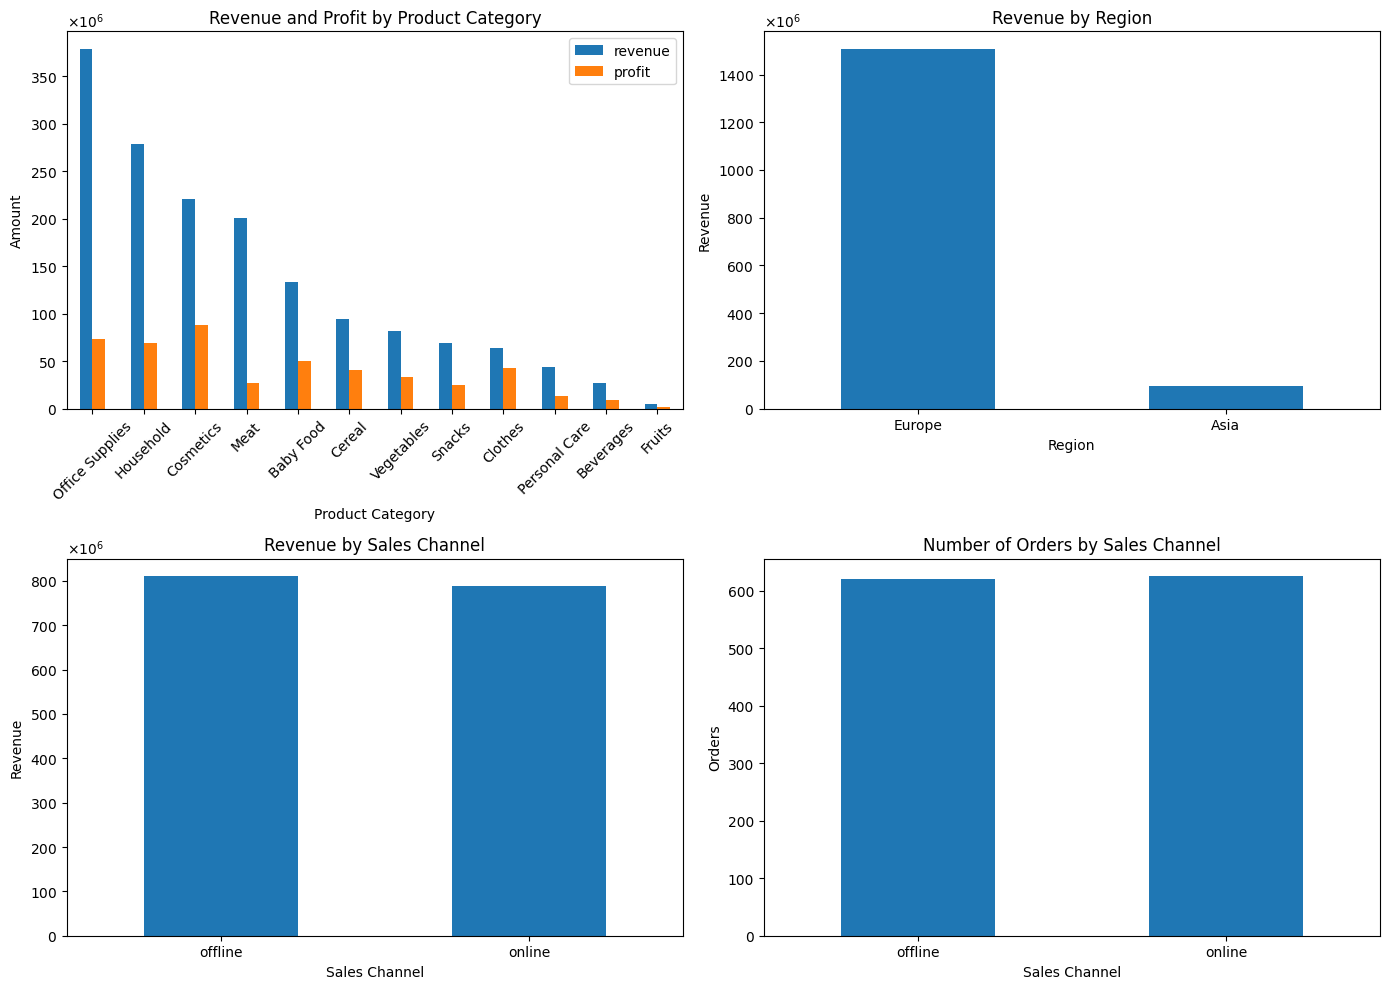

In [24]:
# ---------- Aggregations ----------

# Add total cost per row
df["cost"] = df["units_sold"] * df["unit_cost"]

# By product category
by_item = (
    df.groupby("item_type")
      .agg(
          revenue=("revenue", "sum"),
          cost=("cost", "sum"),
          profit=("profit", "sum"),
          units_sold=("units_sold", "sum")
      )
      .sort_values("revenue", ascending=False)
)


# By region
by_region = (
    df.groupby("region")
      .agg(
          revenue=("revenue", "sum"),
          profit=("profit", "sum")
      )
      .sort_values("revenue", ascending=False)
)

# By sales channel
by_channel = (
    df.groupby("sales_channel")
      .agg(
          revenue=("revenue", "sum"),
          profit=("profit", "sum"),
          orders=("order_id", "nunique")
      )
)

# ---------- Visualizations (2x2) ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Product categories: revenue & profit
by_item[["revenue", "profit"]].plot(kind="bar", ax=axes[0, 0])
axes[0, 0].set_title("Revenue and Profit by Product Category")
axes[0, 0].set_xlabel("Product Category")
axes[0, 0].set_ylabel("Amount")
axes[0, 0].tick_params(axis="x", rotation=45)

# 2) Geography: revenue by region
by_region["revenue"].plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title("Revenue by Region")
axes[0, 1].set_xlabel("Region")
axes[0, 1].set_ylabel("Revenue")
axes[0, 1].tick_params(axis="x", rotation=0)

# 3) Sales channel: revenue
by_channel["revenue"].plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title("Revenue by Sales Channel")
axes[1, 0].set_xlabel("Sales Channel")
axes[1, 0].set_ylabel("Revenue")
axes[1, 0].tick_params(axis="x", rotation=0)

# 4) Sales channel: orders
by_channel["orders"].plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title("Number of Orders by Sales Channel")
axes[1, 1].set_xlabel("Sales Channel")
axes[1, 1].set_ylabel("Orders")
axes[1, 1].tick_params(axis="x", rotation=0)

# ---- Force scientific notation as 1e6 for money charts (not for orders)
for ax in [axes[0, 0], axes[0, 1], axes[1, 0]]:
    ax.ticklabel_format(axis="y", style="sci", scilimits=(6, 6), useMathText=True)

plt.tight_layout()
plt.show()



In [47]:
# --- Europe share of total revenue & profit ---
total_revenue = by_region["revenue"].sum()
total_profit  = by_region["profit"].sum()

europe_revenue = by_region.loc["Europe", "revenue"]
europe_profit  = by_region.loc["Europe", "profit"]

europe_revenue_share = europe_revenue / total_revenue
europe_profit_share  = europe_profit / total_profit

print(f"Europe revenue share: {europe_revenue_share:.1%}")
print(f"Europe profit share : {europe_profit_share:.1%}")

Europe revenue share: 94.2%
Europe profit share : 94.7%


**Revenue and Profit by Product Category**

Графік показує, що найбільший дохід і прибуток генерує категорія **Office Supplies**, за нею йдуть **Household, Cosmetics та Meat**. Категорії з нижчими обсягами доходу (наприклад, **Fruits, Beverages**) роблять незначний внесок у загальний фінансовий результат.

**Revenue by Region**

Регіон **Europe** суттєво домінує за рівнем доходу порівняно з **Asia**, яка має значно менший обсяг продажів.

**Revenue by Sales Channel**

Доходи від **offline** та **online** каналів продажу є порівнянними, з незначною перевагою offline-каналу.

**Number of Orders by Sales Channel**

Кількість замовлень у **online** та **offline** каналах майже однакова.
Попит між каналами розподілений рівномірно, що свідчить про схожу популярність онлайн- та офлайн-продажів серед клієнтів.

In [25]:
# Aggregate sales by country (use alpha-3 codes)
by_country = (
    df.groupby("country_code")  # <- if your alpha-3 column name is different, change here
      .agg(revenue=("revenue", "sum"),
           profit=("profit", "sum"),
           units_sold=("units_sold", "sum"))
      .reset_index()
)

# World map (choropleth) by revenue
fig = px.choropleth(
    by_country,
    locations="country_code",
    color="revenue",
    hover_data=["profit", "units_sold"],
    title="Revenue by Country",
    color_continuous_scale="Blues",
    projection="natural earth"
)

fig.show()


In [26]:
# Top 10 countries by revenue with country name and region
by_country = (
    df.groupby(["region", "country"])
      .agg(
          revenue=("revenue", "sum"),
          profit=("profit", "sum"),
          units_sold=("units_sold", "sum")
      )
      .reset_index()
      .sort_values("revenue", ascending=False)
)

# Display top 10 countries
display(by_country.head(10))



,region,country,revenue,profit,units_sold
11,Europe,Czech Republic,53543932.14,13635593.78,142446
43,Europe,Ukraine,53252317.54,14804925.74,164577
8,Europe,Bosnia and Herzegovina,50117508.49,13257602.77,153545
26,Europe,Macedonia,49222085.25,13684099.95,203078
36,Europe,San Marino,47883708.48,13792992.81,192228
4,Europe,Andorra,47756693.17,15410036.63,185686
33,Europe,Portugal,47172189.84,11345407.59,124825
27,Europe,Malta,47145320.81,14610127.88,173641
35,Europe,Russia,46051659.81,13267682.64,165954
38,Europe,Slovakia,42940998.32,12052790.03,131540


Усі країни з ТОП-10 за доходом належать до регіону **Європа**, що підтверджує її ключову роль у бізнесі компанії. Лідерами за виручкою є **Czech Republic** та **Ukraine**, які також демонструють високі показники прибутку й обсягу проданих одиниць. Країни з меншим населенням, такі як **San Marino**, **Andorra** та **Malta**, все одно входять до ТОП-10, що свідчить про високу інтенсивність продажів або великі середні чеки.

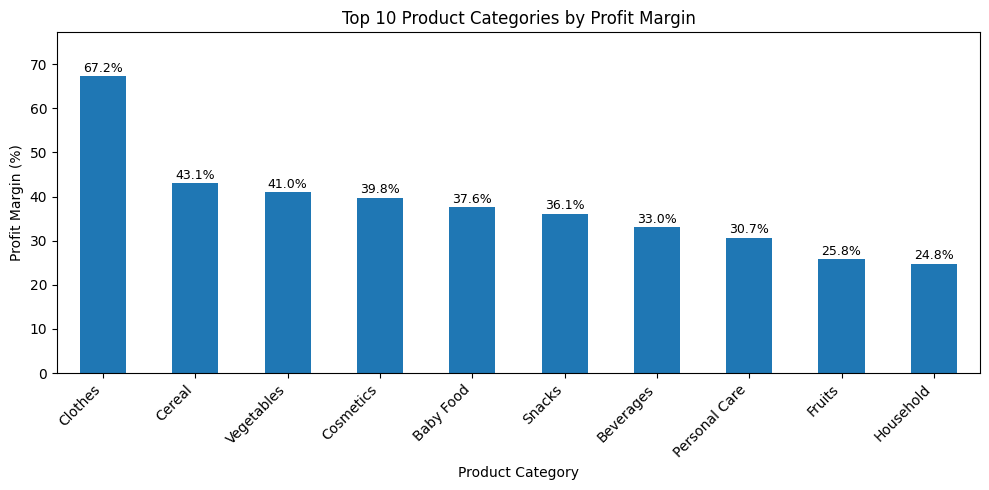

,revenue_mln,profit_mln,profit_margin_pct
item_type,,,
Clothes,63.31,42.54,67.20
Cereal,94.68,40.77,43.07
Vegetables,82.04,33.62,40.98
Cosmetics,221.31,88.01,39.77
Baby Food,133.83,50.26,37.55
Snacks,69.21,25.01,36.14
Beverages,27.43,9.05,33.00
Personal Care,43.35,13.29,30.66
Fruits,4.96,1.28,25.83


Highest margin category: Clothes
Lowest margin category (in top 10): Household


In [44]:
# Top 10 categories by profit margin (clean chart + readable table)

# 1) Calculate margin table
margin_by_item = (
    df.groupby("item_type")
      .agg(revenue=("revenue", "sum"), profit=("profit", "sum"))
      .assign(profit_margin=lambda x: x["profit"] / x["revenue"].replace(0, np.nan))
      .sort_values("profit_margin", ascending=False)
      .head(10)
)

# 2) Plot profit margin (%), with labels
margin_pct = (margin_by_item["profit_margin"] * 100)

ax = margin_pct.plot(kind="bar", figsize=(10, 5))
for i, v in enumerate(margin_pct.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=9)

plt.title("Top 10 Product Categories by Profit Margin")
plt.xlabel("Product Category")
plt.ylabel("Profit Margin (%)")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, max(margin_pct.max() + 10, 10))
plt.tight_layout()
plt.show()

# 3) Readable table (Revenue/Profit in millions)
table_view = margin_by_item.copy()
table_view["revenue_mln"] = table_view["revenue"] / 1e6
table_view["profit_mln"] = table_view["profit"] / 1e6
table_view["profit_margin_pct"] = table_view["profit_margin"] * 100

table_view = table_view[["revenue_mln", "profit_mln", "profit_margin_pct"]].round(2)
display(table_view)

print("Highest margin category:", margin_by_item.index[0])
print("Lowest margin category (in top 10):", margin_by_item.index[-1])

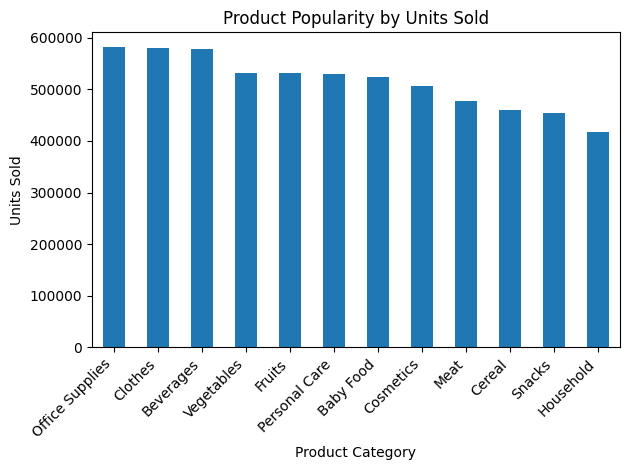

In [28]:
# Analyze product popularity by units sold
popular_products = (
    df.groupby("item_type")
      .agg(units_sold=("units_sold", "sum"))
      .sort_values("units_sold", ascending=False)
)

# Visualization
popular_products.plot(kind="bar", legend=False)
plt.title("Product Popularity by Units Sold")
plt.xlabel("Product Category")
plt.ylabel("Units Sold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Попит на товари є відносно рівномірно розподіленим, однак чітко виділяються кілька лідерів за обсягом продажів. Це означає, що компанія може використовувати популярні категорії як основу для масштабування продажів, а менш популярні — оптимізувати або підтримувати через маркетингові стимули.

count    1246.000000
mean       24.875602
std        14.622855
min         0.000000
25%        12.000000
50%        25.000000
75%        37.000000
max        50.000000
Name: shipping_delay, dtype: float64


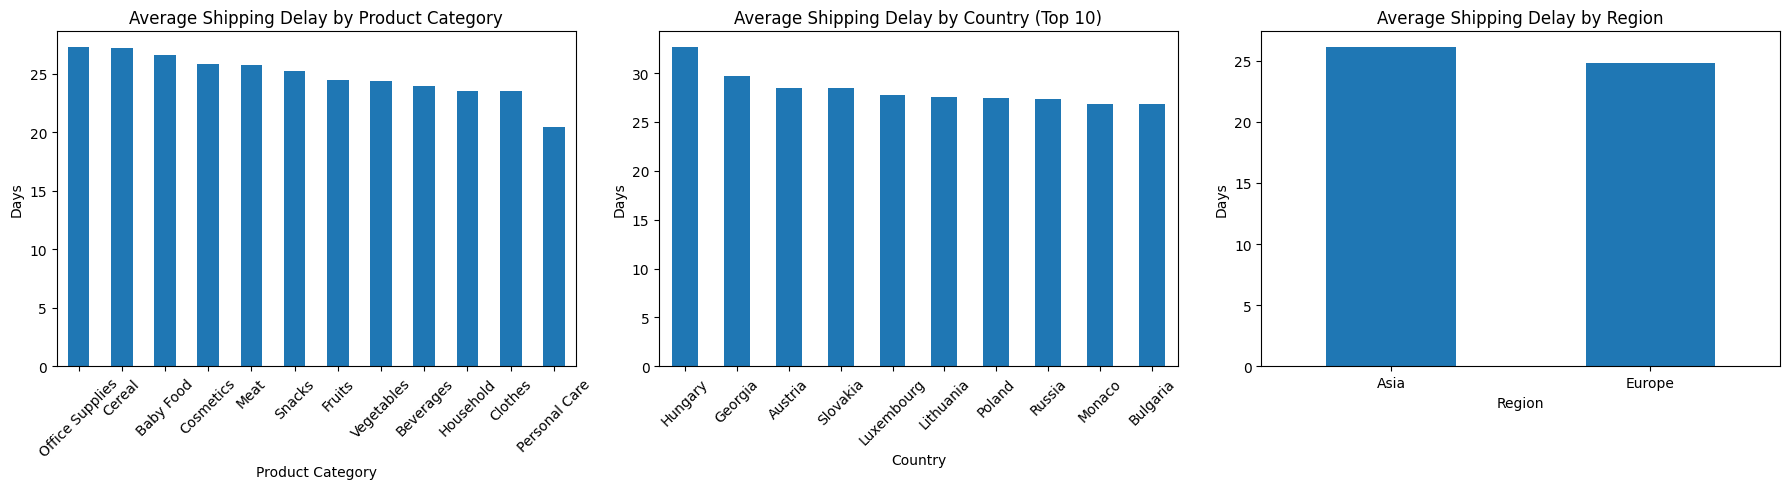

In [29]:
# ---------- Shipping delay analysis ----------

# Create shipping delay in days
df["shipping_delay"] = (df["ship_date"] - df["order_date"]).dt.days

# Basic check
print(df["shipping_delay"].describe())

# ---------- Aggregations ----------

# By product category
delay_by_item = (
    df.groupby("item_type")
      .agg(avg_delay=("shipping_delay", "mean"))
      .sort_values("avg_delay", ascending=False)
)

# By country
delay_by_country = (
    df.groupby("country")
      .agg(avg_delay=("shipping_delay", "mean"))
      .sort_values("avg_delay", ascending=False)
)

# By region
delay_by_region = (
    df.groupby("region")
      .agg(avg_delay=("shipping_delay", "mean"))
      .sort_values("avg_delay", ascending=False)
)

# ---------- Visualizations ----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Product categories
delay_by_item.plot(kind="bar", ax=axes[0], legend=False)
axes[0].set_title("Average Shipping Delay by Product Category")
axes[0].set_xlabel("Product Category")
axes[0].set_ylabel("Days")
axes[0].tick_params(axis="x", rotation=45)

# 2) Countries (top 10 by delay)
delay_by_country.head(10).plot(kind="bar", ax=axes[1], legend=False)
axes[1].set_title("Average Shipping Delay by Country (Top 10)")
axes[1].set_xlabel("Country")
axes[1].set_ylabel("Days")
axes[1].tick_params(axis="x", rotation=45)

# 3) Regions
delay_by_region.plot(kind="bar", ax=axes[2], legend=False)
axes[2].set_title("Average Shipping Delay by Region")
axes[2].set_xlabel("Region")
axes[2].set_ylabel("Days")
axes[2].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()


**Середній час доставки** становить ≈ **24.9 днів.**

**Медіана — 25 днів**, що означає, що половина замовлень доставляється до 25 днів.

**Мінімум** — 0 днів (миттєві/локальні відвантаження).

**Максимум** — 50 днів, що вказує на довгі логістичні ланцюги для окремих замовлень.

Діапазон і стандартне відхилення свідчать про **високу варіативність доставки**.

**Average Shipping Delay by Product Category**

Час відвантаження залежить від типу товару, що може бути пов’язано з особливостями зберігання, логістики або країнами-виробниками. Це означає, що для окремих категорій варто оптимізувати ланцюги постачання.

**Average Shipping Delay by Country (Top 10)**

Логістична ефективність суттєво різниться між країнами, що може бути наслідком географії, інфраструктури або митних процедур. Це потенційні точки для оптимізації логістики.

**Average Shipping Delay by Region**

Регіон **Asia** має дещо більший середній час доставки, ніж **Europe**, хоча різниця між регіонами не є критичною.

Регіональний фактор впливає на швидкість доставки, але основні затримки формуються не лише регіоном, а й конкретними країнами та категоріями товарів.

**Загальний підсумок**

Час доставки є неоднорідним і залежить від категорії товару, країни та регіону. Найбільший потенціал для покращення логістики зосереджений у конкретних країнах і товарних категоріях, а не на рівні регіонів загалом.

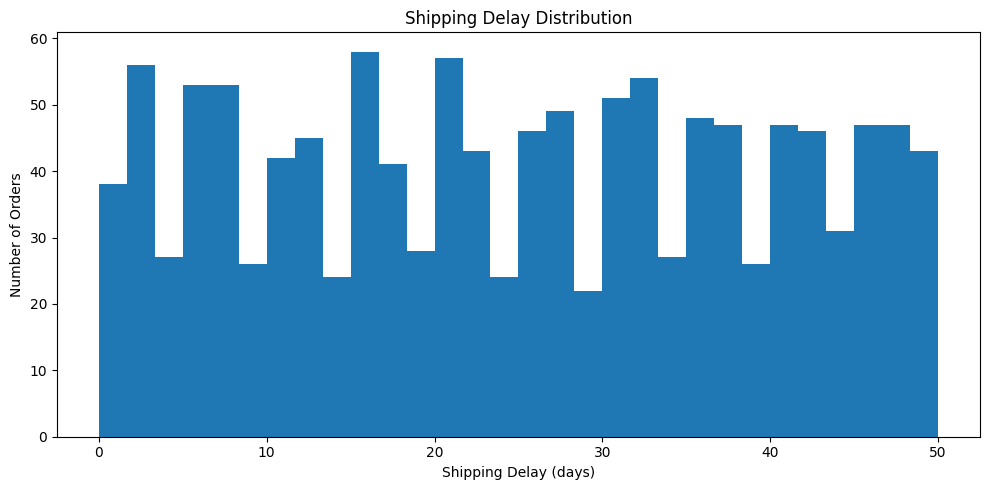

Median (P50): 25 days
P75: 37 days
P90: 45 days
P95: 48 days


In [45]:
# Shipping delay distribution + key percentiles

delay = df["shipping_delay"].dropna()

plt.figure(figsize=(10, 5))
plt.hist(delay, bins=30)
plt.title("Shipping Delay Distribution")
plt.xlabel("Shipping Delay (days)")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

p50 = int(delay.median())
p75 = int(delay.quantile(0.75))
p90 = int(delay.quantile(0.90))
p95 = int(delay.quantile(0.95))

print(f"Median (P50): {p50} days")
print(f"P75: {p75} days")
print(f"P90: {p90} days")
print(f"P95: {p95} days")

**Shipping Delay Insights**

The median shipping time is 25 days, while 90% of orders are delivered within 45 days.
However, the long tail (P95 = 48 days) indicates that a portion of deliveries experiences significant delays.

This suggests that overall logistics performance is stable, but targeted optimization in specific markets or product categories could reduce extreme delays.

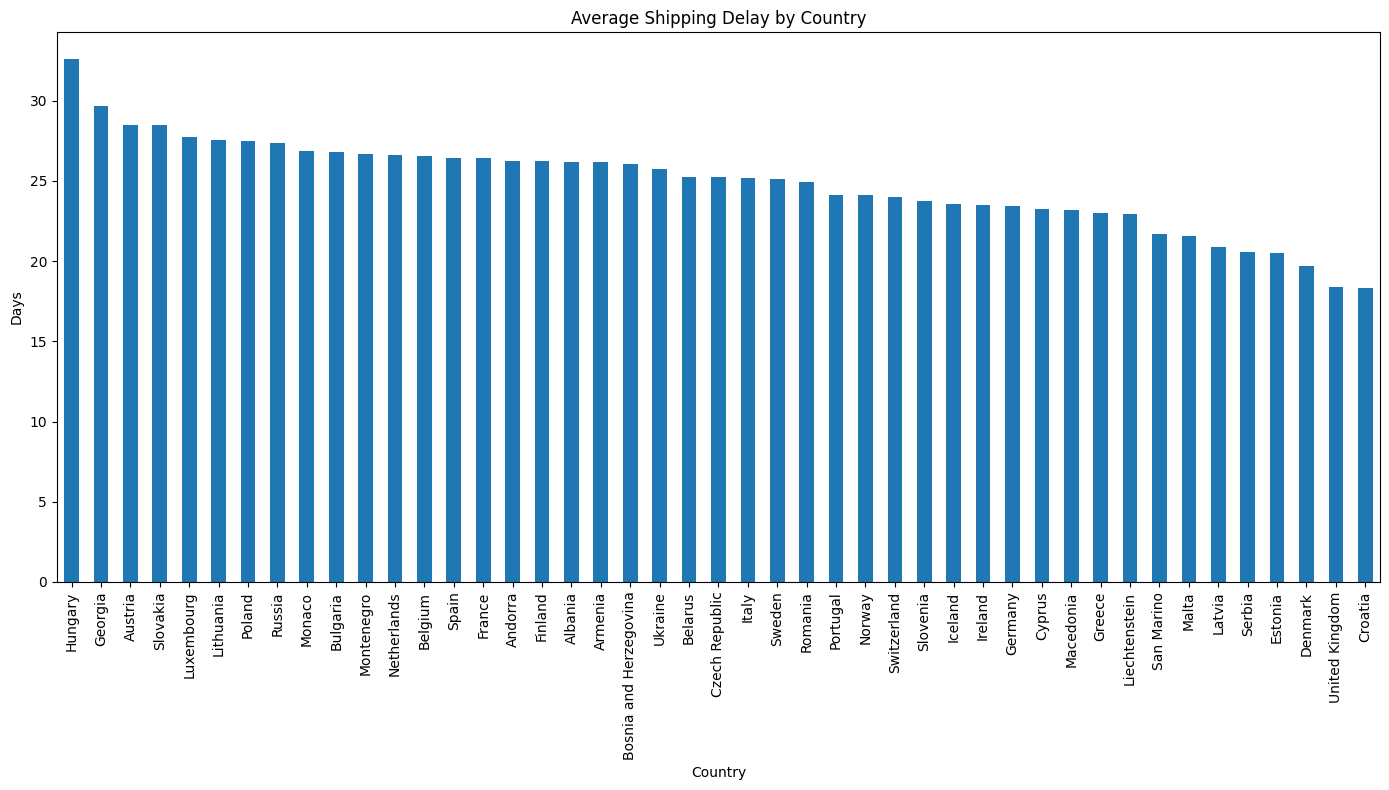

In [30]:
# ---------- Shipping delay by ALL countries ----------

# Average shipping delay by country
delay_by_country = (
    df.groupby("country")
      .agg(avg_delay=("shipping_delay", "mean"))
      .sort_values("avg_delay", ascending=False)
)

# Visualization (all countries)
delay_by_country.plot(kind="bar", figsize=(14, 8), legend=False)
plt.title("Average Shipping Delay by Country")
plt.xlabel("Country")
plt.ylabel("Days")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Графік показує середній час доставки для кожної країни, відсортований від найбільшого до найменшого. Найдовші середні затримки спостерігаються в** Hungary, Georgia, Austria та Slovakia** — понад 28–32 дні. Найкоротший час доставки мають **United Kingdom, Croatia, Denmark та Estonia**, де середній показник опускається до ~18–20 днів.

Різниця між країнами сягає **понад 14 днів**, що є суттєвим логістичним розривом.

Країни з довшою доставкою можуть мати складніші логістичні маршрути, гіршу інфраструктуру або додаткові митні процедури.

Країни з коротшим часом доставки, ймовірно, мають **кращу логістичну ефективність** або ближчі склади постачання.

Час доставки значною мірою залежить від **конкретної країни**, а не лише від регіону загалом. Це означає, що оптимізація логістики має бути **таргетованою по країнах**, з фокусом на ринки з найбільшими затримками, де потенціал покращення є найвищим.

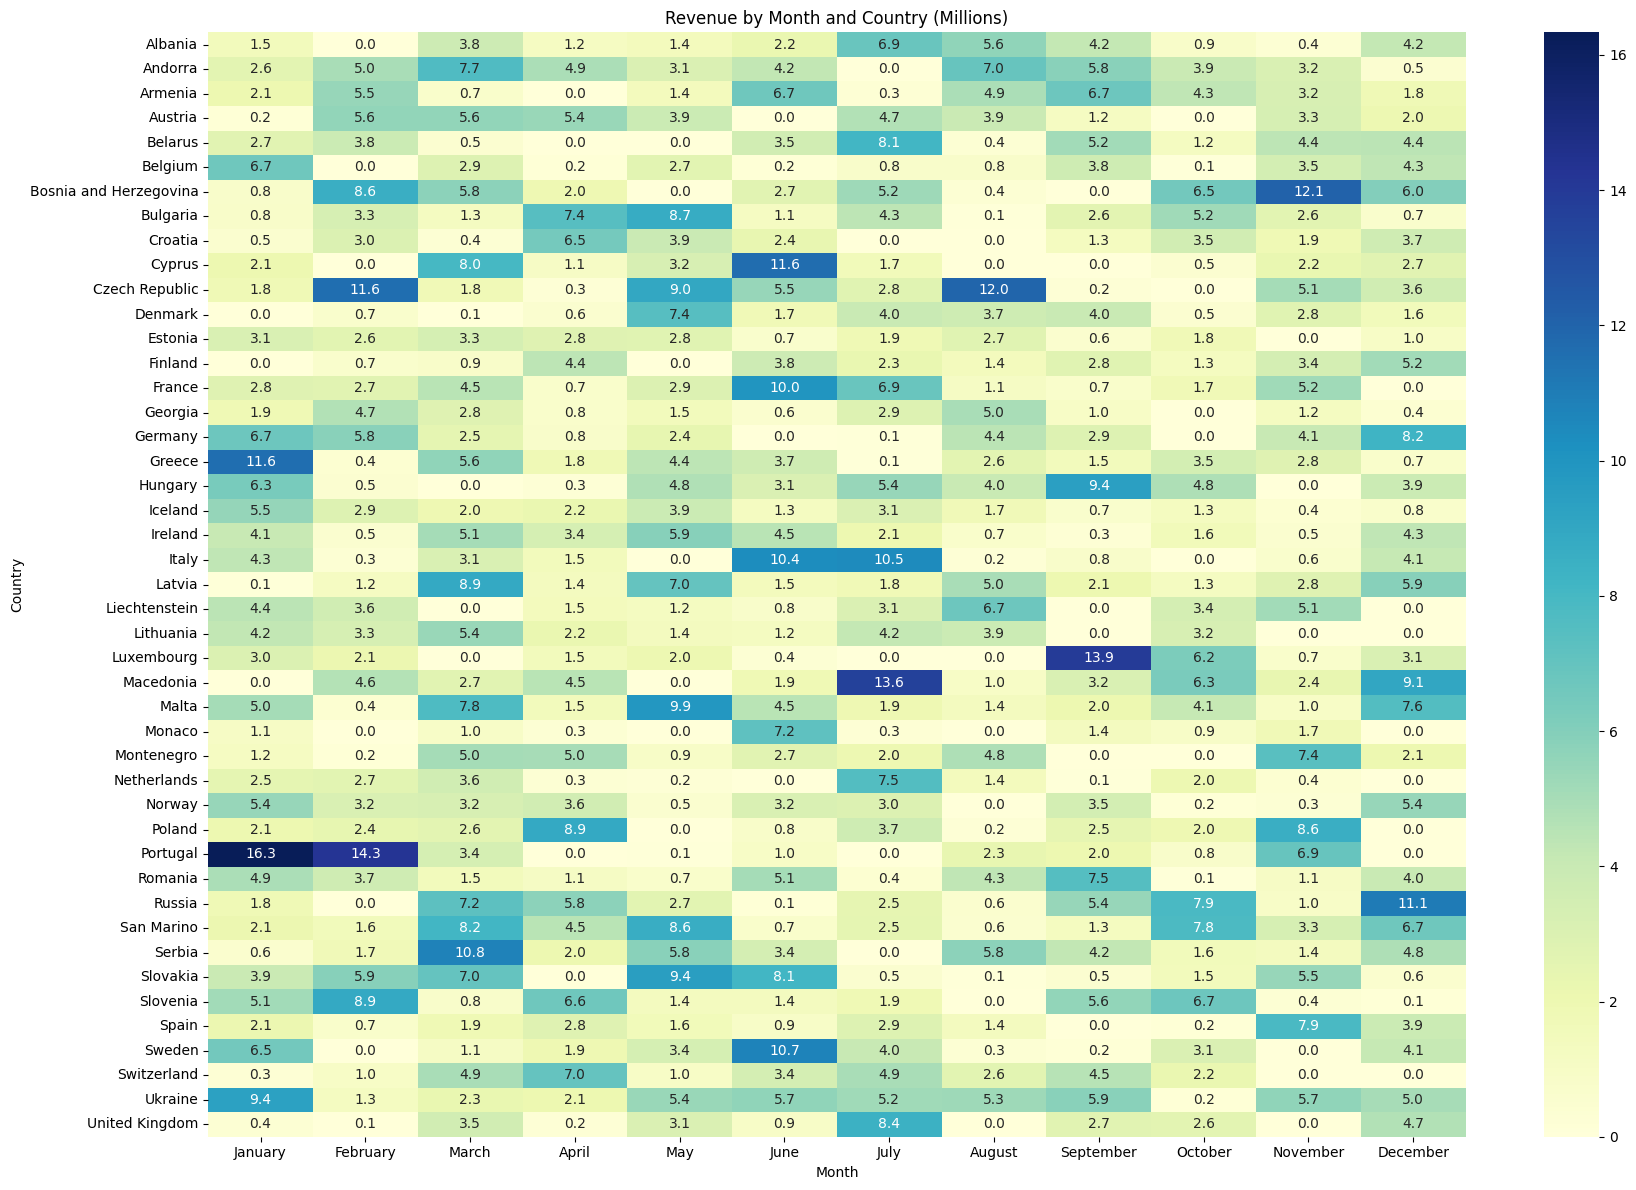

In [31]:
# Create month column
df["month"] = df["order_date"].dt.month_name()

# Month order
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

# Pivot table: revenue by country and month
pivot_table_sales_by_country_month = (
    df.pivot_table(index="country", columns="month", values="revenue", aggfunc="sum")
      .reindex(columns=month_order)
      .fillna(0)
)

# Show values (annot) but keep it readable: format in millions
pivot_mln = pivot_table_sales_by_country_month / 1e6

# Heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(pivot_mln, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Revenue by Month and Country (Millions)")
plt.xlabel("Month")
plt.ylabel("Country")
plt.tight_layout()
plt.show()



Теплова карта відображає помісячний дохід (у мільйонах) для кожної країни. Кольорова інтенсивність зростає від світлих відтінків (низькі значення) до темно-синіх (високі значення), що дозволяє швидко ідентифікувати пікові періоди продажів.

**Ключові спостереження:**

Для більшості країн характерні **нерівномірні продажі протягом року**, з чітко вираженими місячними піками.

**Літні місяці (червень–серпень)** часто демонструють підвищені значення доходу для багатьох європейських країн.

У низці країн (наприклад, **Portugal, Czech Republic, Greece, Ukraine**) спостерігаються **поодинокі дуже високі значення** в окремі місяці, що вказує на великі разові контракти або сезонний попит.

Частина клітинок має значення, близькі до нуля, що свідчить про **відсутність продажів або мінімальну активність** у відповідні місяці.

Продажі компанії мають виражену** місячну сезонність**, причому її характер суттєво відрізняється між країнами. Це означає, що планування запасів, маркетингових кампаній і логістики доцільно здійснювати **індивідуально для кожного ринку**, з урахуванням локальних пікових місяців і періодів спаду.

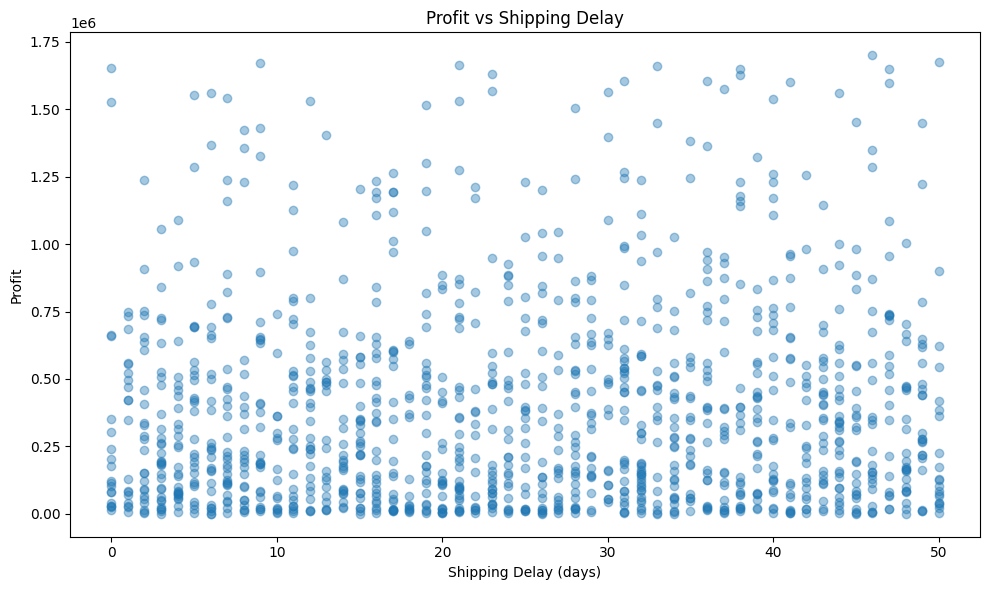

In [32]:
# ---------- Profit vs Shipping Delay analysis ----------

# Scatter: profit vs shipping delay (row level)
plt.figure(figsize=(10, 6))
plt.scatter(df["shipping_delay"], df["profit"], alpha=0.4)
plt.title("Profit vs Shipping Delay")
plt.xlabel("Shipping Delay (days)")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()


На рівні окремих замовлень **прибуток не має сильної прямої залежності від часу відвантаження**. Це означає, що швидша доставка сама по собі не гарантує вищий прибуток, а фінансовий результат більше залежить від інших факторів (категорія товару, обсяг замовлення, ціна, ринок). Оптимізація логістики важлива з точки зору сервісу, але її вплив на прибуток є опосередкованим.

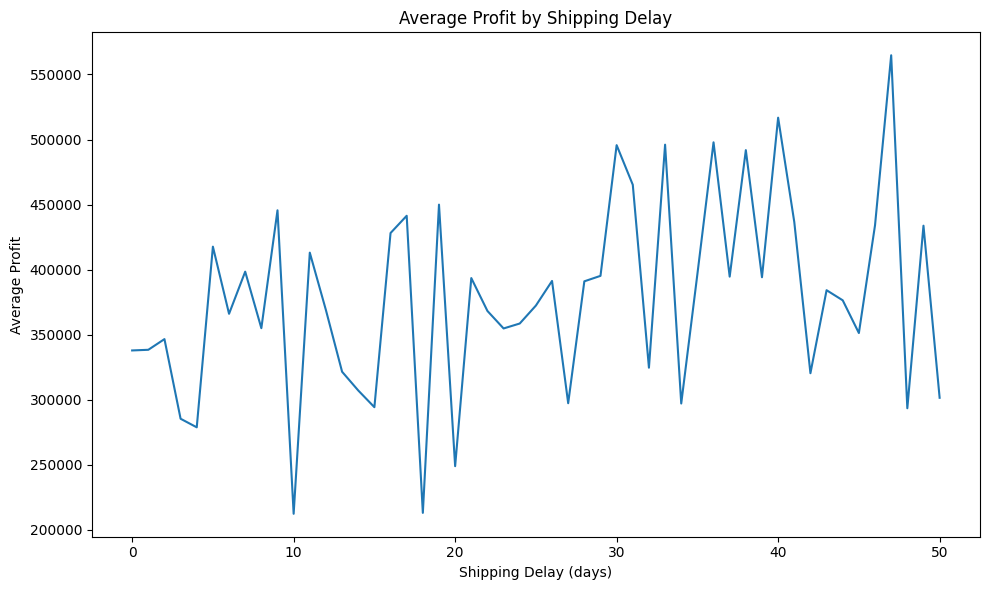

In [33]:
# ---------- Aggregation by shipping delay (mean profit) ----------
profit_by_delay = (
    df.groupby("shipping_delay")
      .agg(avg_profit=("profit", "mean"),
           orders=("order_id", "nunique"))
      .reset_index()
)

# Line plot: average profit by delay
plt.figure(figsize=(10, 6))
plt.plot(profit_by_delay["shipping_delay"], profit_by_delay["avg_profit"])
plt.title("Average Profit by Shipping Delay")
plt.xlabel("Shipping Delay (days)")
plt.ylabel("Average Profit")
plt.tight_layout()
plt.show()


Середній прибуток **не має чіткої системної залежності від часу доставки**. Коливання значень скоріше зумовлені структурою замовлень (обсяг, категорія товару, країна), ніж самим фактом швидкої або повільної доставки. Це підтверджує, що логістика впливає на сервіс і клієнтський досвід, але **не є прямим драйвером прибутку.**

In [34]:
# ---------- Binned analysis (delay groups) ----------
df["delay_group"] = pd.cut(
    df["shipping_delay"],
    bins=[-1, 3, 7, 14, 30, df["shipping_delay"].max()],
    labels=["0–3 days", "4–7 days", "8–14 days", "15–30 days", "30+ days"]
)

profit_by_group = (
    df.groupby("delay_group", observed=True)
      .agg(
          avg_profit=("profit", "mean"),
          total_profit=("profit", "sum"),
          orders=("order_id", "nunique")
      )
      .reset_index()
)

# Round avg_profit to 2 decimals and show total_profit in 1e6 (millions)
profit_by_group["avg_profit"] = profit_by_group["avg_profit"].round(2)
profit_by_group["total_profit"] = profit_by_group["total_profit"] / 1e6

# Optional: rename column to make it clear
profit_by_group = profit_by_group.rename(columns={"total_profit": "total_profit_1e6"})

display(profit_by_group)


,delay_group,avg_profit,total_profit_1e6,orders
0,0–3 days,322991.54,30.361205,94
1,4–7 days,366134.76,40.274823,110
2,8–14 days,355977.43,56.956389,160
3,15–30 days,373148.79,144.035431,386
4,30+ days,407421.75,202.081187,496


Довший час доставки **не знижує прибутковість**, а навпаки асоціюється з **вищим середнім та загальним прибутком**, що, ймовірно, пов’язано з більшими обсягами замовлень або специфікою товарів і ринків. Отже, швидкість доставки не є ключовим драйвером прибутку, а оптимізація логістики має враховувати баланс між витратами, обсягами та типами замовлень.

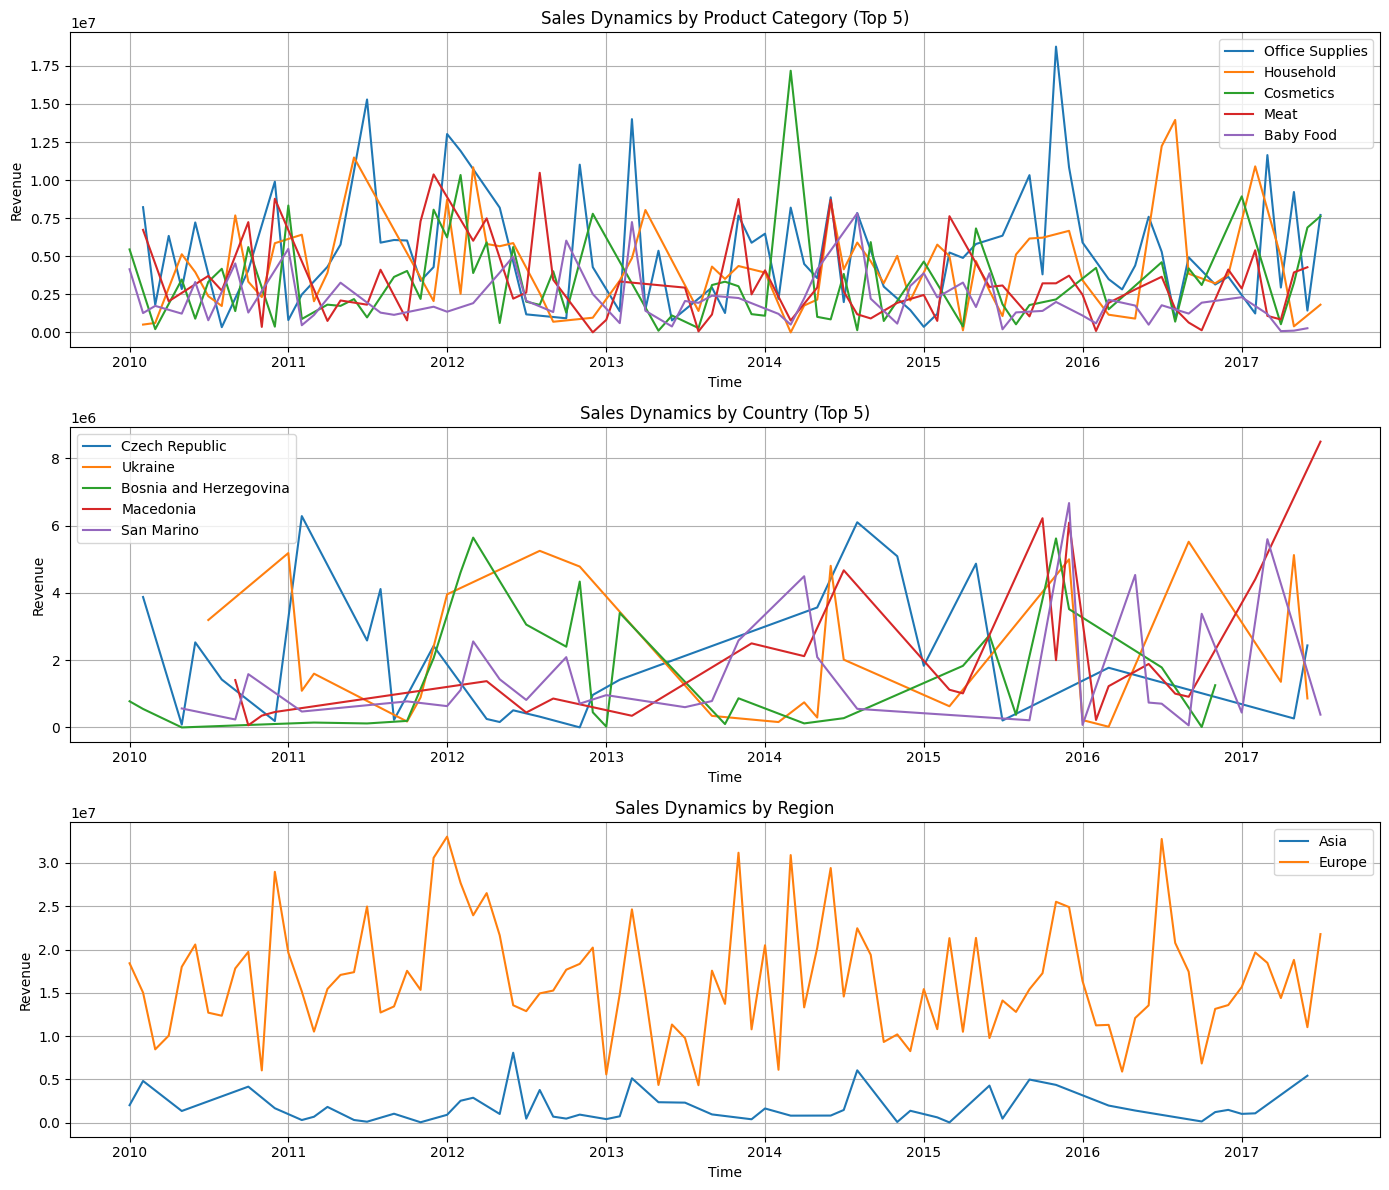

In [35]:
# ---------- Time series preparation ----------

df["year_month"] = df["order_date"].dt.to_period("M").dt.to_timestamp()

# ---------- Aggregations ----------

# 1) Top 5 categories by total revenue
top_items = (
    df.groupby("item_type")["revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index
)

ts_item_top5 = (
    df[df["item_type"].isin(top_items)]
      .groupby(["year_month", "item_type"])
      .agg(revenue=("revenue", "sum"))
      .reset_index()
)

# 2) Top 5 countries by total revenue
top_countries = (
    df.groupby("country")["revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index
)

ts_country_top5 = (
    df[df["country"].isin(top_countries)]
      .groupby(["year_month", "country"])
      .agg(revenue=("revenue", "sum"))
      .reset_index()
)

# 3) By region
ts_region = (
    df.groupby(["year_month", "region"])
      .agg(revenue=("revenue", "sum"))
      .reset_index()
)

# ---------- Visualizations ----------

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1) Product categories (Top 5)
for item in top_items:
    data = ts_item_top5[ts_item_top5["item_type"] == item]
    axes[0].plot(data["year_month"], data["revenue"], label=item)

axes[0].set_title("Sales Dynamics by Product Category (Top 5)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Revenue")
axes[0].legend()
axes[0].grid(True)

# 2) Countries (Top 5)
for c in top_countries:
    data = ts_country_top5[ts_country_top5["country"] == c]
    axes[1].plot(data["year_month"], data["revenue"], label=c)

axes[1].set_title("Sales Dynamics by Country (Top 5)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Revenue")
axes[1].legend()
axes[1].grid(True)

# 3) Regions
for r in ts_region["region"].unique():
    data = ts_region[ts_region["region"] == r]
    axes[2].plot(data["year_month"], data["revenue"], label=r)

axes[2].set_title("Sales Dynamics by Region")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Revenue")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


Продажі компанії демонструють виражену сезонність і нерівномірну динаміку з окремими різкими сплесками у певні періоди, що може бути пов’язано з промоакціями або великими разовими замовленнями. Основна частина доходу стабільно генерується в Європі та зосереджена в кількох ключових товарних категоріях, які формують фінансове ядро бізнесу. Водночас Азія та окремі категорії з високими, але нерегулярними піками продажів виглядають перспективними напрямами для подальшого масштабування та інвестицій.

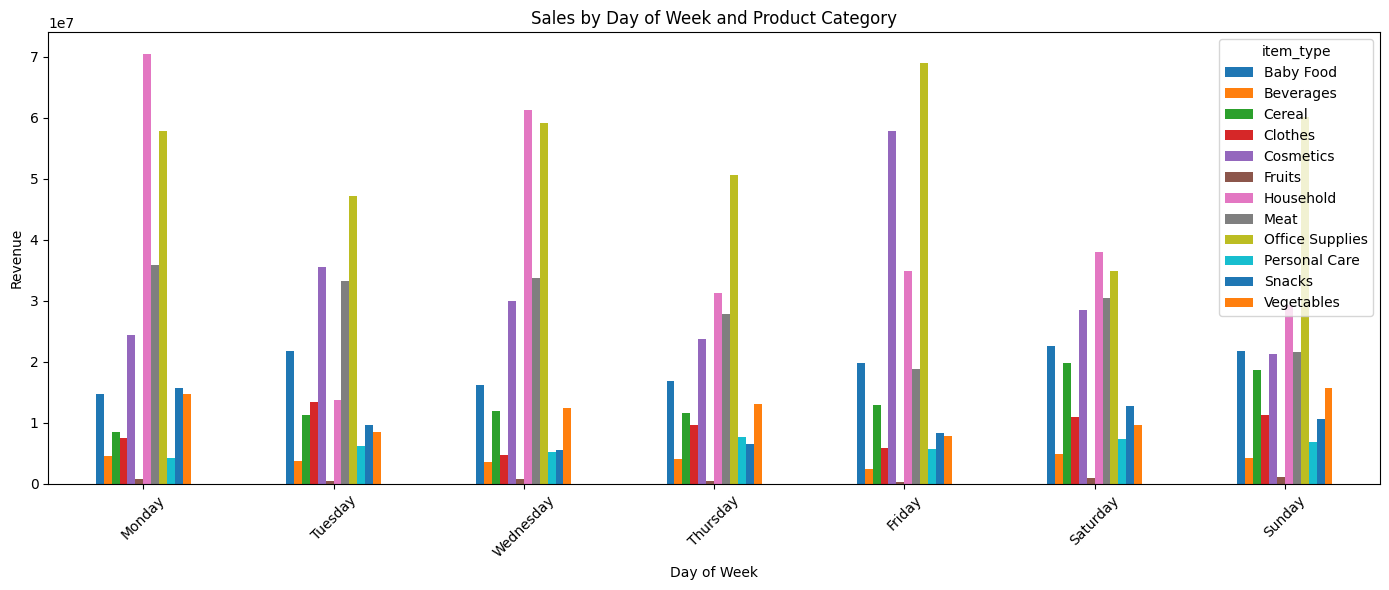

In [36]:
# ---------- Sales by weekday analysis ----------

# Extract weekday name from order date
df["weekday"] = df["order_date"].dt.day_name()

# Define correct weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
                 "Friday", "Saturday", "Sunday"]

# Aggregate revenue by weekday and product category
sales_by_weekday = (
    df.groupby(["weekday", "item_type"])
      .agg(revenue=("revenue", "sum"))
      .reset_index()
)

# Pivot for visualization
pivot_weekday = sales_by_weekday.pivot(
    index="weekday",
    columns="item_type",
    values="revenue"
).reindex(weekday_order)

# Visualization
pivot_weekday.plot(
    kind="bar",
    figsize=(14, 6)
)

plt.title("Sales by Day of Week and Product Category")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Office Supplies** та **Household** мають чітко вищі продажі у **будні дні (понеділок–п’ятниця)** і спад на вихідних — це типово для товарів, пов’язаних з офісною та побутовою активністю.

**Cosmetic** і **Meat** демонструють **піки наприкінці тижня та у вихідні**, що відповідає споживчій поведінці перед вихідними.

**Snacks, Beverages, Vegetables** виглядають більш рівномірно, без чітко вираженого дня-піку, тобто **не мають явної тижневої сезонності.**

**Висновок:**
Так, окремі категорії (Office Supplies, Household, Cosmetics, Meat) демонструють **сталу залежність від дня тижня**, тому їх можна вважати сезонними на тижневому рівні, тоді як інші товари продаються більш рівномірно.

# **4. Reporting**

**1. Продажі та прибутковість**

Основний дохід і прибуток формуються кількома ключовими товарними категоріями — передусім **Office Supplies, Household** та **Cosmetics**, які формують фінансове ядро бізнесу.

Популярність товарів за кількістю проданих одиниць розподілена відносно рівномірно, однак зазначені категорії стабільно забезпечують вищу маржинальність та обсяги доходу.

Онлайн- та офлайн-канали продажу демонструють співставні обсяги доходу та кількість замовлень, що свідчить про ефективну мультиканальну модель без залежності від одного каналу.

**2. Географія продажів**

Європа генерує **94.2% загального доходу та 94.7% загального прибутку**, що свідчить про критично високу географічну концентрацію бізнесу.

Така структура забезпечує операційну стабільність на ключовому ринку, проте формує концентраційний ризик у випадку макроекономічних або регуляторних змін у регіоні.

Інші регіони, зокрема Азія, поки що мають значно меншу частку, однак можуть розглядатися як потенційні напрями диверсифікації та довгострокового зростання.

**3. Динаміка продажів у часі**

Продажі мають хвилеподібний характер із періодичними сплесками, що вказує на наявність сезонності та вплив зовнішніх факторів.

Відсутність єдиного тренду на рівні всіх категорій підтверджує різну поведінку товарних груп і ринків.

**4. Аналіз по днях тижня**

Для частини товарних категорій спостерігається виражена тижнева сезонність.

Офісні та побутові товари продаються активніше у будні дні, тоді як окремі споживчі категорії мають піки ближче до вихідних.

Це відкриває можливість для адаптації маркетингових активностей та планування запасів відповідно до поведінки клієнтів.

**5. Логістика та час доставки**

Медіанний час доставки становить близько 25 днів із варіативністю залежно від країни та категорії товару.

Розподіл часу доставки має правосторонню асиметрію, що свідчить про наявність окремих екстремальних затримок.

**6. Зв’язок логістики та прибутку**

На рівні окремих замовлень не виявлено прямої негативної залежності між прибутком і часом доставки.

Замовлення з довшим часом доставки демонструють вищий сукупний прибуток, що, ймовірно, пов’язано з більшим обсягом або специфікою товарів.

Отже, логістика є важливою з точки зору клієнтського досвіду та операційної ефективності, проте не виступає ключовим драйвером прибутковості.

**Загальний бізнес-висновок**

Бізнес компанії базується на сильних товарних категоріях і майже повній географічній концентрації в Європі.

Модель продажів є стабільною та збалансованою між онлайн- і офлайн-каналами.

Основні можливості для стратегічного розвитку полягають у:

*   географічній диверсифікації поза межами Європи,
*   масштабуванні високорентабельних категорій,
*   точковій оптимізації логістики в країнах із підвищеними затримками.

Поточна структура демонструє операційну стійкість, але водночас містить концентраційний ризик, що потребує врахування у довгостроковому плануванні.